In [1]:
# ---------------------- Imports ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# ---------------------- Vector Quantizer ----------------------
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z):
        # z: [B, D, H, W] → [BHW, D]
        z_perm = z.permute(0, 2, 3, 1).contiguous()
        flat_z = z_perm.view(-1, self.embedding_dim)

        # Distance to embeddings
        distances = (flat_z.pow(2).sum(1, keepdim=True)
                     - 2 * flat_z @ self.embeddings.weight.t()
                     + self.embeddings.weight.pow(2).sum(1))

        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embeddings(encoding_indices).view(z_perm.shape)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # Losses
        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = z + (quantized - z).detach()

        return quantized, loss

In [3]:
# ---------------------- VQ-VAE Model ----------------------
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),   # 28x28 → 14x14
            nn.ReLU(),
            nn.Conv2d(32, embedding_dim, 4, stride=2, padding=1),  # 14x14 → 7x7
            nn.ReLU()
        )
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 32, 4, stride=2, padding=1),  # 7x7 → 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),              # 14x14 → 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss = self.quantizer(z)
        x_hat = self.decoder(quantized)
        return x_hat, vq_loss

In [7]:
# ---------------------- Training Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

loss_curve = []
epochs = 30

In [8]:

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [9]:
# ---------------------- Training Loop ----------------------
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, vq_loss = model(x)
        recon_loss = F.mse_loss(x_hat, x)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_curve.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.6591
Epoch 2, Loss: 0.0690
Epoch 3, Loss: 0.0386
Epoch 4, Loss: 0.0333
Epoch 5, Loss: 0.0300
Epoch 6, Loss: 0.0290
Epoch 7, Loss: 0.0289
Epoch 8, Loss: 0.0284
Epoch 9, Loss: 0.0280
Epoch 10, Loss: 0.0278
Epoch 11, Loss: 0.0276
Epoch 12, Loss: 0.0274
Epoch 13, Loss: 0.0273
Epoch 14, Loss: 0.0269
Epoch 15, Loss: 0.0268
Epoch 16, Loss: 0.0268
Epoch 17, Loss: 0.0268
Epoch 18, Loss: 0.0268
Epoch 19, Loss: 0.0268
Epoch 20, Loss: 0.0268
Epoch 21, Loss: 0.0268
Epoch 22, Loss: 0.0269
Epoch 23, Loss: 0.0269
Epoch 24, Loss: 0.0268
Epoch 25, Loss: 0.0268
Epoch 26, Loss: 0.0268
Epoch 27, Loss: 0.0268
Epoch 28, Loss: 0.0269
Epoch 29, Loss: 0.0269
Epoch 30, Loss: 0.0269


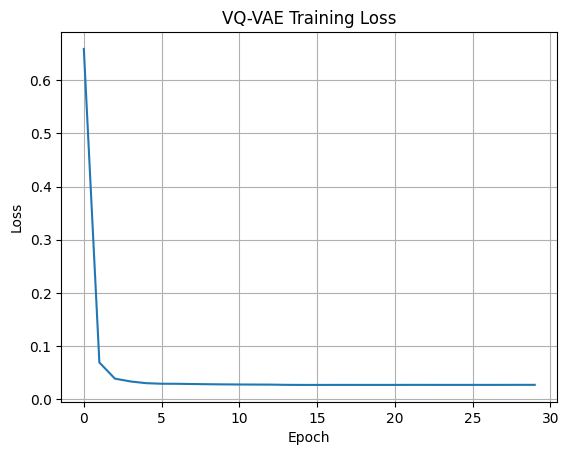

In [10]:
# ---------------------- Plot Loss Curve ----------------------
plt.plot(loss_curve)
plt.title("VQ-VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


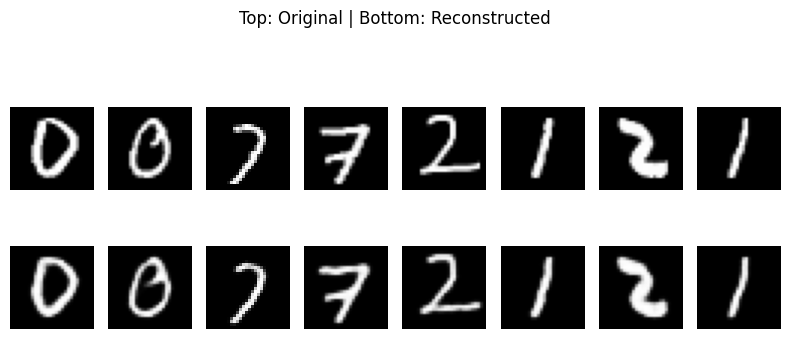

In [11]:

# ---------------------- Reconstruction ----------------------
model.eval()
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        x = x.cpu().numpy()
        x_hat = x_hat.cpu().numpy()
        break

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(x[i][0], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 8, i + 9)
    plt.imshow(x_hat[i][0], cmap='gray')
    plt.axis('off')

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.tight_layout()
plt.show()

In [12]:
# Fit a GMM on latents

all_latents = []
model.eval()
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        z_e = model.encoder(x)  # [B, D, H, W]
        z_e = z_e.permute(0, 2, 3, 1).contiguous().view(-1, model.quantizer.embedding_dim)
        all_latents.append(z_e.cpu())

all_latents = torch.cat(all_latents, dim=0).numpy()

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=100, covariance_type='full', random_state=0)
gmm.fit(all_latents)

In [ ]:
samples = gmm.sample(n_samples=16 * 7 * 7)[0]  # for 16 images of 7x7 codes
samples = torch.tensor(samples, dtype=torch.float32).view(16, 7, 7, -1).to(device)


In [ ]:
# Flatten and compute nearest codebook vectors
flat = samples.view(-1, samples.shape[-1])
dist = (flat.pow(2).sum(1, keepdim=True)
        - 2 * flat @ model.quantizer.embeddings.weight.t()
        + model.quantizer.embeddings.weight.pow(2).sum(1))
encoding_indices = torch.argmin(dist, dim=1)

# Get quantized vectors
quantized = model.quantizer.embeddings(encoding_indices)
quantized = quantized.view(16, 7, 7, -1).permute(0, 3, 1, 2).contiguous()


In [ ]:
with torch.no_grad():
    generated = model.decoder(quantized)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated[i][0].cpu(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()